# Uncertainty Estimates from Classifiers

Los modelos no solo tienen la capacidad de identificar a qué clase pertenece una muestra, sino que también permiten evaluar la certeza de esta predicción. En otras palabras, podemos determinar cuán confiables son los valores asignados por el modelo y qué tan seguros estamos de que la predicción es correcta. Veamoslo con un ejemplo:

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

import sys
sys.path.insert(1,'C:\\Users\\dylan.velo\\OneDrive - Softtek\\Documents\\Machine Learning')
import plots

from sklearn.datasets import make_circles, load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils import Bunch

In [2]:
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# we rename the classes "blue" and "red" for illustration purposes:
y_named = np.array(["blue", "red"])[y]

# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

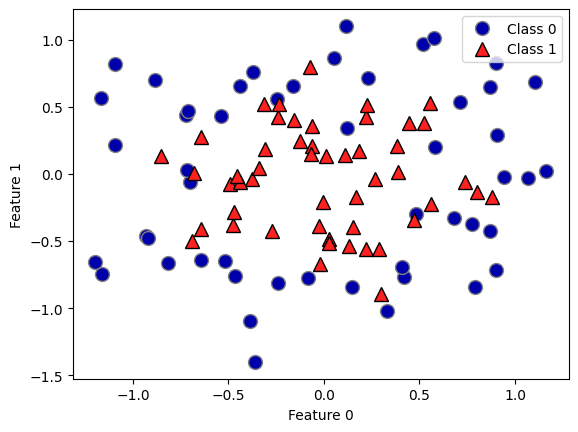

In [3]:
plt.figure()
ax = plt.gca()
plots.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
plt.legend(["Class 0", "Class 1"], loc='best')

## The Decision Function

Con el método decision_function, el valor proporcionado indica cuán seguro está el modelo de que el punto de datos pertenece a la clase positiva. Los números positivos suelen indicar una preferencia por la primera clase, mientras que los números negativos sugieren una inclinación hacia la otra clase. El modelo genera un rango de valores, pero estos números son arbitrarios y dependen de los datos utilizados. Lo importante a tener en cuenta es si el número es positivo o negativo; cuanto más alejado del 0 esté el valor, mayor es la certeza del modelo sobre la clase correspondiente.

In [4]:
print("X_test.shape:", X_test.shape)
print("Decision function shape:",
      gbrt.decision_function(X_test).shape)

X_test.shape: (25, 2)
Decision function shape: (25,)


In [5]:
# show the first few entries of decision_function
print("Decision function:", gbrt.decision_function(X_test)[:6])

Decision function: [ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


In [6]:
print("Thresholded decision function:\n",
      gbrt.decision_function(X_test) > 0)
print("Predictions:\n", gbrt.predict(X_test))

Thresholded decision function:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [7]:
# make the boolean True/False into 0 and 1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# use 0 and 1 as indices into classes_
pred = gbrt.classes_[greater_zero]
# pred is the same as the output of gbrt.predict
print("pred is equal to predictions:",
      np.all(pred == gbrt.predict(X_test)))

pred is equal to predictions: True


In [8]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


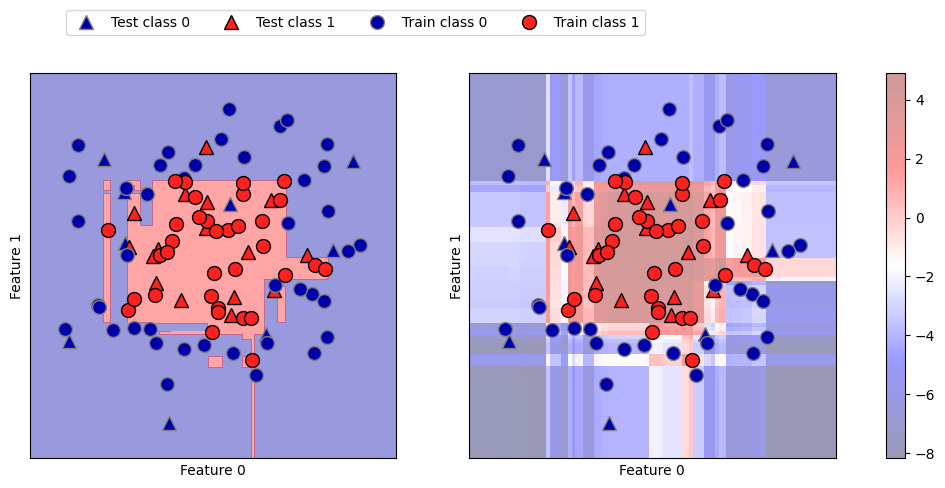

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
cm = ListedColormap(['#0000aa', '#ff2020'])
plots.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=cm)
scores_image = plots.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=plt.get_cmap('seismic'))

for ax in axes:
    # plot training and test points
    plots.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    plots.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)

axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

## Predicting Probabilities

Cuando analizamos la probabilidad, el método predict_proba nos proporciona la probabilidad de que una muestra pertenezca a cada una de las clases posibles. Para cada registro, obtendremos la probabilidad de que sea de la primera clase y la probabilidad de que sea de la segunda clase. Dado que se trata de probabilidades, la suma de las probabilidades para todas las clases debe ser siempre igual a 1, por lo tanto la clase que tenga el mayor porcentaje sera la predecida.

Es importante tener en cuenta que un modelo que presenta sobreajuste (overfitting) tiende a generar valores con alta precisión, es decir, valores muy cercanos al 100% para una clase específica. Esto ocurre porque el modelo se ajusta demasiado a los datos de entrenamiento, capturando incluso el ruido. Por otro lado, un modelo menos complejo, que es menos propenso al sobreajuste, tiende a mostrar menos seguridad en sus predicciones, resultando en valores más moderados y menos extremos.

In [12]:
print("Shape of probabilities:", gbrt.predict_proba(X_test).shape)

Shape of probabilities: (25, 2)


In [13]:
# show the first few entries of predict_proba
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test[:6]))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


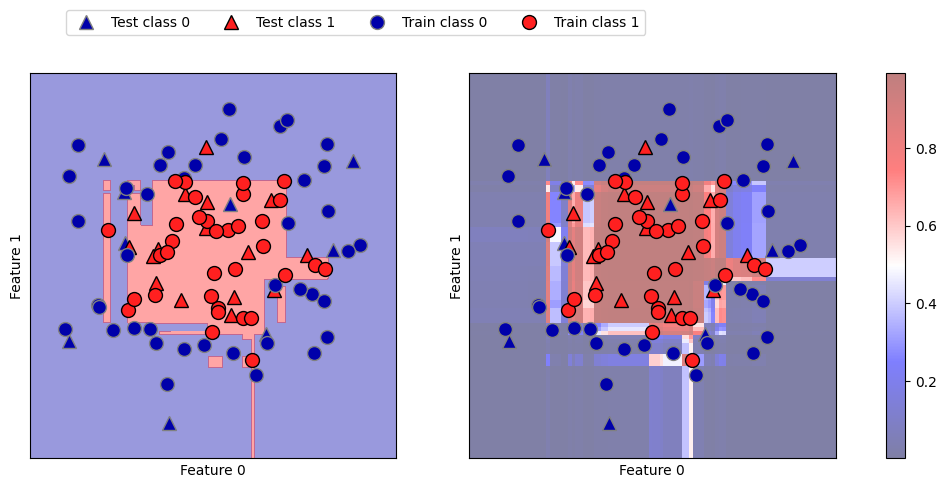

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
cm = ListedColormap(['#0000aa', '#ff2020'])
plots.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=cm)
scores_image = plots.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=plt.get_cmap('seismic'), function='predict_proba')

for ax in axes:
    # plot training and test points
    plots.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    plots.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

## Multiclass Classification

En un contexto de clasificación multiclase, como en el conjunto de datos Iris, los métodos como decision_function también son útiles para evaluar la confianza del modelo en sus predicciones. Para cada punto de datos, decision_function proporciona un valor numérico que indica la seguridad del modelo en su predicción. Un valor mayor sugiere que el modelo está más seguro de que el punto pertenece a esa clase específica, mientras que un valor menor indica menor certeza.

En el caso de múltiples clases, el modelo calculará estos valores para cada clase. La clase con el valor numérico más alto será la clase predicha, ya que representa la mayor confianza del modelo en esa predicción. Esta capacidad de evaluar la seguridad en las predicciones es esencial para interpretar el desempeño del modelo y entender cómo maneja la incertidumbre en problemas de clasificación multiclase.

In [18]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [19]:
print("Decision function shape:", gbrt.decision_function(X_test).shape)
# plot the first few entries of the decision function
print("Decision function:")
print(gbrt.decision_function(X_test)[:6, :])

Decision function shape: (38, 3)
Decision function:
[[-0.89604809  1.14724958 -0.82754003]
 [ 1.16113086 -0.80789044 -0.82827067]
 [-0.89091511 -0.77671169  1.19653416]
 [-0.89604809  1.14724958 -0.82754003]
 [-0.89763468  0.96497584 -0.10374792]
 [ 1.16113086 -0.80789044 -0.82827067]]


In [20]:
print("Argmax of decision function:")
print(np.argmax(gbrt.decision_function(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


Para cada punto de datos, predict_proba proporciona un conjunto de probabilidades que suman 1, correspondientes a las probabilidades asignadas a cada clase. Estas probabilidades reflejan cuán seguro está el modelo respecto a cada clase. Una mayor probabilidad para una clase indica que el modelo está más seguro de que el punto pertenece a esa clase. Por lo tanto, la clase con la probabilidad más alta será la predicción final del modelo.

In [21]:
# show the first few entries of predict_proba
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test)[:6])
# show that sums across rows are one
print("Sums:", gbrt.predict_proba(X_test)[:6].sum(axis=1))

Predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
Sums: [1. 1. 1. 1. 1. 1.]


In [22]:
print("Argmax of predicted probabilities:")
print(np.argmax(gbrt.predict_proba(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [23]:
logreg = LogisticRegression()

# represent each target by its class name in the iris dataset
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data:", logreg.classes_)
print("predictions:", logreg.predict(X_test)[:10])
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function:", argmax_dec_func[:10])
print("argmax combined with classes_:",
      logreg.classes_[argmax_dec_func][:10])

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
